In [72]:
import pandas as pd
from paths import *
from tqdm import tqdm
import os
from datetime import timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [16]:
print(OUTPUT_PATH)

E:\NaUKMA\ComputationalSS\ExploringReddit\reddit_processed


In [20]:
csv_files = list((OUTPUT_PATH / 'comments').glob('*.csv'))
dfs = []
for csv_file in tqdm(csv_files, desc="Files", position=0):
    temp = pd.read_csv(csv_file)
    dfs.append(temp)
    tqdm.write(f"{csv_file.name}: {len(temp):,} rows")

Files:  14%|█▍        | 1/7 [00:03<00:22,  3.68s/it]

RC_2023-08.csv: 721,414 rows


Files:  29%|██▊       | 2/7 [00:07<00:17,  3.54s/it]

RC_2023-09.csv: 692,328 rows


Files:  43%|████▎     | 3/7 [00:18<00:27,  6.97s/it]

RC_2023-10.csv: 2,194,076 rows


Files:  57%|█████▋    | 4/7 [00:25<00:21,  7.30s/it]

RC_2023-11.csv: 1,428,245 rows


Files:  71%|███████▏  | 5/7 [00:31<00:13,  6.80s/it]

RC_2023-12.csv: 1,083,343 rows


Files:  86%|████████▌ | 6/7 [00:36<00:06,  6.15s/it]

RC_2024-01.csv: 933,772 rows


Files: 100%|██████████| 7/7 [00:41<00:00,  5.90s/it]

RC_2024-02.csv: 824,620 rows


In [22]:
df = pd.concat(dfs, ignore_index=True)

In [35]:
print('Rows =', df.shape[0], '\nColumns =', df.shape[1])

Rows = 7877798 
Columns = 6


In [30]:
df['created'] = pd.to_datetime(df['created'], format='%Y-%m-%d %H:%M')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7877798 entries, 0 to 7877797
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   author     object        
 1   subreddit  object        
 2   score      int64         
 3   created    datetime64[ns]
 4   link       object        
 5   body       object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 360.6+ MB


In [32]:
df.head(5)

,author,subreddit,score,created,link,body
0,u/lisztomania_0,AskMiddleEast,1,2023-08-01 03:00:00,https://www.reddit.com/r/AskMiddleEast/comment...,It is an über talent that has become an über t...
1,u/JakeTheSandMan,worldnews,1,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,“Armada” \n\nI prefer to call them floating hu...
2,u/justnmirrrs,worldnews,1,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,"70% of France electricity is nuclear, so it co..."
3,u/liquid_cherry,worldnews,1,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,In the United States you can burn the Bible an...
4,u/Grouchy-Bad-4190,AskMiddleEast,1,2023-08-01 03:00:00,https://www.reddit.com/r/AskMiddleEast/comment...,Good


In [33]:
df.to_csv(OUTPUT_PATH / 'joined_comments.csv', index=False)

In [40]:
print("Size in MEGAbytes:", os.path.getsize(OUTPUT_PATH / 'joined_comments.csv') // (1024 * 1024))

Size in MEGAbytes: 2671


<Axes: xlabel='subreddit'>

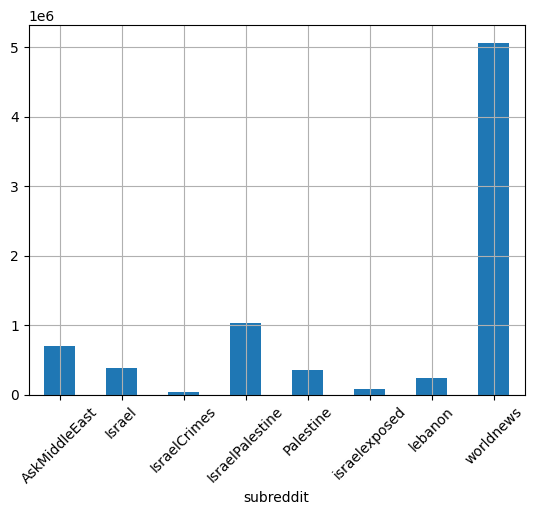

In [53]:
df.groupby('subreddit')['subreddit'].count().plot(kind='bar', grid=True, rot=45)

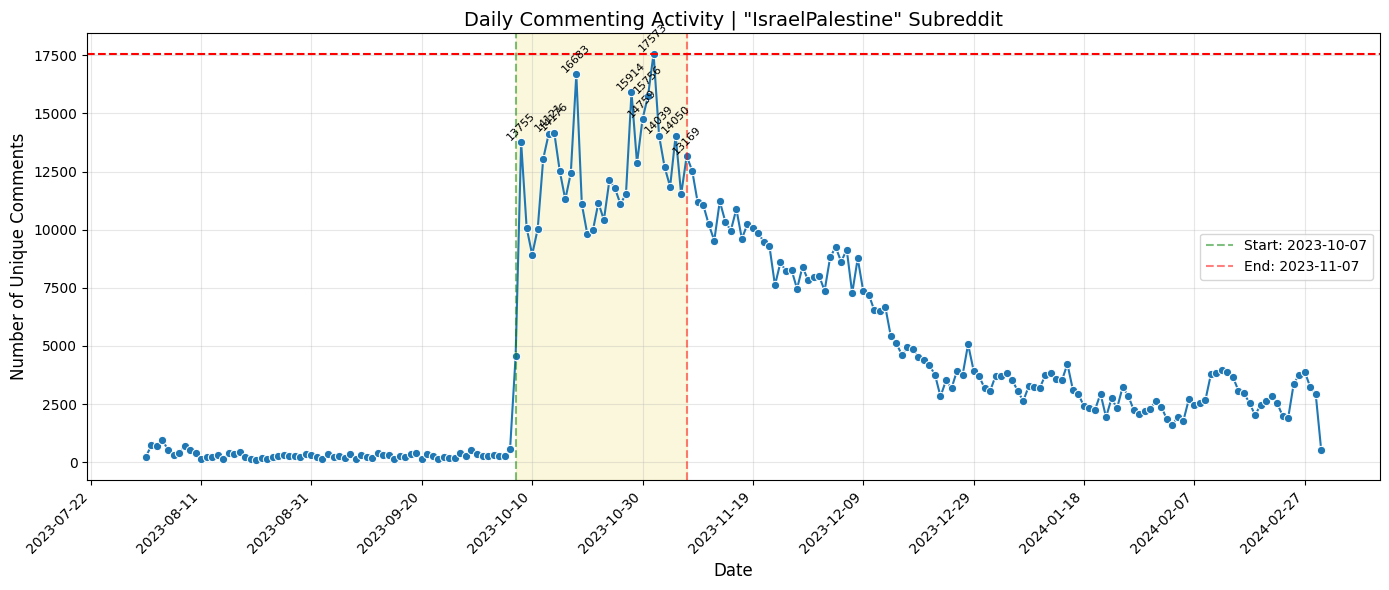

In [76]:
filtered_df = df[df['subreddit'] == 'IsraelPalestine'].copy()
filtered_df = filtered_df.drop_duplicates(subset=['author', 'body'], keep='first')

filtered_df['date'] = pd.to_datetime(filtered_df['created']).dt.date

daily_counts = filtered_df['date'].value_counts().sort_index()
daily_counts_df = daily_counts.reset_index()
daily_counts_df.columns = ['Date', 'Comment_Count']

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Comment_Count', data=daily_counts_df, marker='o')

threshold = daily_counts_df['Comment_Count'].quantile(0.95)

above_threshold = daily_counts_df[daily_counts_df['Comment_Count'] > threshold]

first_date = above_threshold['Date'].min() - timedelta(days=1)
last_date = above_threshold['Date'].max()
plt.axvline(first_date, color='green', linestyle='--', alpha=0.5, label=f'Start: {first_date}')
plt.axvline(last_date, color='red', linestyle='--', alpha=0.5, label=f'End: {last_date}')
plt.axvspan(first_date, last_date, color='khaki', alpha=0.3)
for idx, row in daily_counts_df.iterrows():
    if row['Comment_Count'] > threshold:
        plt.text(row['Date'], row['Comment_Count'], str(row['Comment_Count']),
                ha='center', va='bottom', fontsize=8, rotation=45)

plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))  # Max 15 date labels
plt.axhline(y=daily_counts_df['Comment_Count'].max(), color='r', linestyle='--')

plt.title('Daily Commenting Activity | "IsraelPalestine" Subreddit', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Unique Comments', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()